# Tarea: Entendimiento de los datos

## Introducción
A continuación, se desarrolla la entrega grupal de Entendimiento de Datos, de la semana 4.


## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python necesarios.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType, TimestampType
from pyspark.sql.functions import udf, col, countDistinct, length, isnan, when, count, max as spark_max, to_date, year, to_timestamp, expr, substring, min, corr
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark.

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
db_user = 'Estudiante_8_202413'
db_psswd = 'MISO_aabb1122'
PATH='./'

## Perfilamiento de los datos

### Información dada por la organización

- Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018
- Se tiene la información de proyecciones de vida por género y edad para los 32 departamentos desde 2005 hasta 2015
- El total de hombres de valle del cauca para 2014 es 2110069
- Hay información de 605.448 vuelos entre 2004 y 2018 y de 865 aeropuertos construidos desde 2013 hasta 2020
- Hay información de 7879 centros poblados


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre y traer la información total de la tabla que se requiere. A continuación, se presentan las consultas a las 5 tablas principales.

In [17]:
sql_aeropuertos = 'ProyectoTransaccional.aeropuertosCopia'

In [18]:
sql_divipola = 'ProyectoTransaccional.divipolaCopia'

In [23]:
sql_vuelos = 'ProyectoTransaccional.vuelosCopia2'

In [24]:
sql_pib = 'ProyectoTransaccional.PIBCopia'

In [25]:
sql_proyecciones = 'ProyectoTransaccional.proyeccionesCopia'

In [26]:
#Se cargan los dataframes desde la base de datos
aeropuertos = obtener_dataframe_de_bd(db_connection_string, sql_aeropuertos, db_user, db_psswd)
divipola = obtener_dataframe_de_bd(db_connection_string, sql_divipola, db_user, db_psswd)
vuelos = obtener_dataframe_de_bd(db_connection_string, sql_vuelos, db_user, db_psswd)
pib = obtener_dataframe_de_bd(db_connection_string, sql_pib, db_user, db_psswd)
proyecciones = obtener_dataframe_de_bd(db_connection_string, sql_proyecciones, db_user, db_psswd)


### Entendimiento general de datos
A continuación, se presentan las tablas las cuales serán la fuente de datos.

In [27]:
aeropuertos.show(7)

+-----+----+--------------------+--------------------+------------+----------+-------+--------+-----------------+--------------------+--------------+-----------+------+-----------+---------+----------+------------------+--------------+-----+---------+--------------------+----------------+-------------+
|sigla|iata|              nombre|           municipio|departamento| categoria|latitud|longitud|      propietario|          explotador|longitud_pista|ancho_pista|  pbmo|orientacion|elevacion|resolucion|fecha_construccion|fecha_vigencia|clase|     tipo|numero_vuelos_origen|gcd_departamento|gcd_municipio|
+-----+----+--------------------+--------------------+------------+----------+-------+--------+-----------------+--------------------+--------------+-----------+------+-----------+---------+----------+------------------+--------------+-----+---------+--------------------+----------------+-------------+
|  9cg|    |san jose del ariporo|      Paz de Ariporo|    casanare|AerÃ³dromo|    500|-7

Para la tabla de aeropuertos, se tiene la siguiente información relacionada, detallando el nombre de la columna y su correspondiente descripción:
- sigla: Código formado por grupos de tres letras que designan a cada aeropuerto de Colombia
- iata: Código IATA (International Air Transport Association)
- nombre: Nombre del aeropuerto o aeródromo
- municipio: Municipio en el cual se ubica el aeropuerto o aeródromo
- departamento: Departamento en el cual se ubica el aeropuerto o aeródromo
- categoria: Categoría del aeropuerto o aeródromo
- latitud: Latitud en la cual se encuentra ubicado el aeropuerto
- longitud: Longitud en la cual se encuentra ubicado el aeropuerto
- propietario: Propietario del aeropuerto o aeródromo
- explotador: Explotador del aeropuerto o aeródromo
- longitud_pista: Longitud medida en metros de la pista
- ancho_pista: Ancho medido en metros de la pista
- pbmo: Peso bruto máximo operacional (PBMO)
- elevacion: Elevación del aeropuerto o aeródromo
- resolucion: Número de resolución de construcción del aeropuerto o aeródromo
- fecha_construccion: Fecha en la que se construyó el aeropuerto o aeródromo
- fecha_vigencia: Fecha hasta la cual el aeropuerto(aeródromo) se encuentra vigente para su funcionamiento
- clase: Tolerabilidad del riesgo del aeropuerto o aeródromo
- tipo: Uso se que le da al aeropuerto o aeródromo
- numero_vuelos_origen: Número total de vuelos cuyo origen es el aeropuerto o aeródromo del último año registrado
- gcd_departamento: Código departamental en el cual se encuentra ubicado el establecimiento
- gcd_municipio: Código municipal en el cual se encuentra ubicado el establecimiento
- anio: Año en el cual se registró el dato

In [28]:
divipola.show(7)

+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|Código Departamento|Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|      Longitud|       Latitud|Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|                 41|           91001|             91001033|           amazonas|           NEIVA| COMUNIDAD INDÍGEN...|     CENTRO POBLADO|-70.0285785394|-4.11198257304|               |                               MUNICIPIO|               

Para la tabla de divipola, se tiene la siguiente información relacionada, detallando el nombre de la columna y su correspondiente descripción:
- CodigoDepartamento: Identificador del departamento
- CodigoMunicipio: Identificador del Municipio
- CodigoCentroPoblado: Identificador del centro poblado
- NombreDepartamento: Nombre del departamento en el que esta ubicado el centro poblado
- NombreMunicipio: Nombre del municipio en el que esta ubicado el centro poblado
- NombreCentroPoblado: Nombre del centro poblado
- TipoCentroPoblado: Tipo: centro poblado o cabecera municipal
- Longitud: Longitud de ubicación del centro poblado
- Latitud: Latitud de ubicación del centro poblado
- NombreDistrito: Nombre del distrito del que hace parte el centro poblado
- Municipio/AreasNoMunicipalizadas(ANM): Indicador de si es municipio o area no municipalizada
- NombreAreaMetropolitana: Nombre del area metropolitana del centro poblado

In [29]:
vuelos.show(7)

+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
| ano|mes|origen|destino|tipo_equipo|tipo_vuelo|trafico| empresa|vuelos|sillas|carga_ofrecida|pasajeros|carga_bordo|
+----+---+------+-------+-----------+----------+-------+--------+------+------+--------------+---------+-----------+
|2004|  1|   bog|    mia|       B752|         R|      I|AMERICAN|     0|     0|           0.0|        0|        0.0|
|2004|  7|   bog|    mia|       B752|         R|      I|AMERICAN|    62| 11656|      327236.0|     7864|   118443.0|
|2004|  9|   bog|    mia|       B752|         R|      I|AMERICAN|    32|  6016|      168896.0|     4283|    73896.0|
|2004|  3|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     3473|   203724.0|
|2004|  7|   bog|    mia|       B763|         R|      I|AMERICAN|    31|  6572|      351540.0|     4994|   219965.0|
|2004|  9|   bog|    mia|       B763|         R|      I|AMERICAN

Para la tabla de vuelos, se tiene la siguiente información relacionada, detallando el nombre de la columna y su correspondiente descripción:
- ano: Año en el cual se registró el dato
- mes: Mes en el cual se registró el dato
- origen: Sigla IATA del aeropuerto donde se origina el trayecto
- destino: Sigla IATA del aeropuerto donde termina el trayecto
- tipo_equipo: Código del tipo de avión utilizado para realizar el trayecto
- tipo_vuelo: Tipo de operación realizada entre ciudades (e.g., R, T)
- trafico: Tipo de tráfico (e.g., Internacional, nacional)
- empresa: Nombre comercial de la empresa (Aerolínea)
- vuelos: Número de vuelos realizados en el mes especificado
- sillas: Número total de asientos de pasajeros disponibles para la venta
- carga_ofrecida: Capacidad de carga total disponible para el transporte de carga y correo
- pasajeros: Número de pasajeros cuyo transporte le genera una remuneración comercial a la empresa
- carga_bordo: Carga total transportada que le genera una remuneración comercial a la empresa

In [30]:
pib.show(7)

+----------------------------+--------------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|CodigoDepartamento(DIVIPOLA)|       DEPARTAMENTOS|   2006|    2007|                2008|                2010|    2011|    2012|                2013|    2014|
+----------------------------+--------------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|                          41|                uila|6895658| 7441987|   8686536.103258422|    9548624.85406653|11113741|11400169|1.1967750469189592E7|12755711|
|                          18|            CaquetÃ¡|3575615| 4060678|   4519574.129383702|   5048396.606737779| 5516404| 6476778|    7161524.44383983| 7990249|
|                           8|          AtlÃ¡ntico|7194985| 8299825|   8858405.054387597|   9481200.322350295|10288314|11421539|1.2434114309437651E7|13681473|
|                          63|            Quin

Para la tabla de pib, se tiene la siguiente información relacionada, detallando el nombre de la columna y su correspondiente descripción:
- CodigoDepartamento(DIVIPOLA): Identificador del departamento
- DEPARTAMENTOS: Nombre del departamento
- 2006: Valor de PIB para el 2006 de cada departamento
- 2007: Valor de PIB para el 2007 de cada departamento
- 2008: Valor de PIB para el 2008 de cada departamento
- 2009: Valor de PIB para el 2009 de cada departamento
- 2010: Valor de PIB para el 2010 de cada departamento
- 2011: Valor de PIB para el 2011 de cada departamento
- 2012: Valor de PIB para el 2012 de cada departamento
- 2013: Valor de PIB para el 2013 de cada departamento
- 2014: Valor de PIB para el 2014 de cada departamento
- 2015: Valor de PIB para el 2015 de cada departamento
- 2016: Valor de PIB para el 2016 de cada departamento
- 2017: Valor de PIB para el 2017 de cada departamento
- 2005: Valor de PIB para el 2005 de cada departamento

Acá se puede observar que la columna *CodigoDepartamento(DIVIPOLA)* es un identificador que corresponde a una llave foránea de la tabla divipola.

In [31]:
proyecciones.show(7)

+----+---+---------+-------------+-------------+
|Anio| DP|    DPNOM|Total Hombres|Total Mujeres|
+----+---+---------+-------------+-------------+
|2005| 25|antioquia|      2630787|      2830056|
|2006| 25|antioquia|      2663957|      2864164|
|2007| 25|antioquia|      2697202|      2897978|
|2008| 25|antioquia|      2730505|      2931594|
|2009| 25|antioquia|      2764235|      2966142|
|2010| 25|antioquia|      2798757|      3001403|
|2011| 25|antioquia|      2833245|      3035946|
+----+---+---------+-------------+-------------+
only showing top 7 rows



Para la tabla de proyecciones, se tiene la siguiente información relacionada, detallando el nombre de la columna y su correspondiente descripción:
- AÑO: Año de la proyección
- DP: Identificador del departamento
- DPNOM: Nombre del departamento
- AREA GEOGRAFICA: Indicador de si es municipio, centro poblado o el total
- Hombres_i: Valor proyectado total de hombres de edad i en ese año y departamento
- Mujeres_i: Valor proyectado total de mujeres de edad i en ese año y departamento
- Total_i: Valor proyectado total de hombres y mujeres de edad i en ese año y departamento
- Total Hombres: Valor proyectado total de hombres en ese año y departamento
- Total Mujeres: Valor proyectado total de mujeres en ese año y departamento
- Total: Valor proyectado total de hombres y mujeres en ese año y departamento

Ahora bien, a continuación se tienen los esquemas de los DataFrame de cada tabla, donde se incluye los nombres de las columnas asi como el tipo de dato.

In [32]:
aeropuertos.schema

StructType(List(StructField(sigla,StringType,true),StructField(iata,StringType,true),StructField(nombre,StringType,true),StructField(municipio,StringType,true),StructField(departamento,StringType,true),StructField(categoria,StringType,true),StructField(latitud,IntegerType,true),StructField(longitud,StringType,true),StructField(propietario,StringType,true),StructField(explotador,StringType,true),StructField(longitud_pista,IntegerType,true),StructField(ancho_pista,DoubleType,true),StructField(pbmo,StringType,true),StructField(orientacion,StringType,true),StructField(elevacion,StringType,true),StructField(resolucion,StringType,true),StructField(fecha_construccion,StringType,true),StructField(fecha_vigencia,StringType,true),StructField(clase,StringType,true),StructField(tipo,StringType,true),StructField(numero_vuelos_origen,DoubleType,true),StructField(gcd_departamento,IntegerType,true),StructField(gcd_municipio,IntegerType,true)))

In [33]:
divipola.schema

StructType(List(StructField(Código Departamento,IntegerType,true),StructField(Código Municipio,IntegerType,true),StructField(Código Centro Poblado,IntegerType,true),StructField(Nombre Departamento,StringType,true),StructField(Nombre Municipio,StringType,true),StructField(Nombre Centro Poblado,StringType,true),StructField(Tipo Centro Poblado,StringType,true),StructField(Longitud,DoubleType,true),StructField(Latitud,DoubleType,true),StructField(Nombre Distrito,StringType,true),StructField(Municipio/Áreas No Municipalizadas (ANM),StringType,true),StructField(Nombre Área Metropolitana,StringType,true)))

In [34]:
vuelos.schema

StructType(List(StructField(ano,IntegerType,true),StructField(mes,StringType,true),StructField(origen,StringType,true),StructField(destino,StringType,true),StructField(tipo_equipo,StringType,true),StructField(tipo_vuelo,StringType,true),StructField(trafico,StringType,true),StructField(empresa,StringType,true),StructField(vuelos,IntegerType,true),StructField(sillas,IntegerType,true),StructField(carga_ofrecida,DoubleType,true),StructField(pasajeros,IntegerType,true),StructField(carga_bordo,DoubleType,true)))

In [35]:
pib.schema

StructType(List(StructField(CodigoDepartamento(DIVIPOLA),LongType,true),StructField(DEPARTAMENTOS,StringType,true),StructField(2006,LongType,true),StructField(2007,LongType,true),StructField(2008,DoubleType,true),StructField(2010,DoubleType,true),StructField(2011,LongType,true),StructField(2012,LongType,true),StructField(2013,DoubleType,true),StructField(2014,LongType,true)))

In [36]:
proyecciones.schema

StructType(List(StructField(Anio,IntegerType,true),StructField(DP,IntegerType,true),StructField(DPNOM,StringType,true),StructField(Total Hombres,IntegerType,true),StructField(Total Mujeres,IntegerType,true)))

**¿Qué es una fila de cada fuente compartida?** 
Con estos análisis, y para responder a la pregunta de "Significado de una fila", se puede concluir que cada fila de de cada tabla representa cada información que se tiene de su correspondiente tabla, el cual indica por ejemplo que para la tabla aeropuerto se tiene su nombre, su sigla de referencia a ser conocido, el lugar geaográfico en donde se encuentra, las dimensiones, y toda la información relevante; para la tabla divipola se tiene los códigos relevantes de identificación, el nombre del departamento, los tamaños y nombre del lugar donde se encuentra ubicado, entre otros; para la tabla de PIB se tiene el identificador del departamento y su nombre, como también la información del PIB para cada año entre 2005 y 2017 por cada departamento; para la tabla vuelos, se tiene la información de fecha de cada vuelo, el tipo, el origen y destino del vuelo, la información del avion en el sentido de número de sillas, pasajeros y carga, el tráfico, entre otra información relevante; y finalmente para la tabla proyecciones, se tiene el año de la proyección, el identificador del departamento, el nombre y su indicador de si es municipio, centro poblado o total, la información demográfica proyectada para hombres, mujeres y demás información relevante. Esto es entonces, toda la representación de la información que se tiene para poder indagar y dar un buen seguimiento a toda la parte poblacional.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [37]:
print((aeropuertos.count(), len(aeropuertos.columns)))

(547, 23)


In [38]:
print((divipola.count(), len(divipola.columns)))

(9508, 12)


In [39]:
print((vuelos.count(), len(vuelos.columns)))

(467990, 13)


In [40]:
print((pib.count(), len(pib.columns)))

(27, 10)


In [41]:
print((proyecciones.count(), len(proyecciones.columns)))

(330, 5)


**¿Cuantos datos nos compartieron para el proyecto?**
Para responder a la pregunta de "Cantidad de registros y cantidad de columnas por tipo de dato", se tiene que en total de cantidad de registros, hay 547 aeropuertos, 9.508 divipola, 467.990 vuelos, 27 PIB y 330 proyecciones. 

Ahora bien, para las variables que son las columnas por tipo de dato, se tiene que hay 23 variables que componen la tabla de aeropuertosCopia, dentro de las cuales se tiene 4 de tipo numérico, 2 de tipo numérico con decimal y 17 de tipo cadena de caracteres; 12 variables que componen la tabla de divipolaCopia, dentro de las cuales se tiene 3 de tipo numérico, 2 de tipo numérico con decimal y 7 de tipo cadena de caracteres; 13 variables que componen la tabla de vuelosCopia2, dentro de las cuales se tiene 4 de tipo numérico, 2 de tipo numérico con decimal y 7 de tipo cadena de caracteres; 10 variables que componen la tabla de PIBCopia, dentro de las cuales se tiene 6 de tipo numérico, 3 de tipo numérico con decimal y 1 de tipo cadena de caracteres; y 5 variables que componen la tabla de proyeccionesCopia, dentro de las cuales se tiene 4 de tipo numérico, 0 de tipo numérico con decimal y 1 de tipo cadena de caracteres.

### Revisión de reglas de negocio
Primero se confirman las reglas proporcionadas por el negocio

#### Regla 1: La cantidad máxima de productos movidos es 50 millones por transacción

In [13]:
print(movimientos.agg(spark_max("Cantidad")).collect()[0][0])

67368.0


El análisis confirma que la cantidad máxima de productos movidos por transacción registrada en los datos es de 67,368, lo cual está dentro del límite aceptable de 50 millones. Por lo tanto, se puede concluir que los datos cumplen con esta regla de negocio específica. Este resultado contribuye a la confianza en la integridad y la calidad de los datos de movimientos de inventario de WWImporters.

#### Regla 2: Existen 236.668 movimientos de producto realizados desde eñ año 2013

In [14]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Extraer el año considerando teniendo en cuenta que se tien la fecha en multiples formatos
movimientosAnio = movimientos.withColumn(
    "AnioTransaccion",
    when(col("FechaTransaccion").rlike("^[A-Za-z]{3} \\d{2},\\d{4}$"), substring(col("FechaTransaccion"), -4, 4).cast("int"))
    .otherwise(substring(col("FechaTransaccion"), 1, 4).cast("int"))
)
# Filtrar los movimientos realizados desde 2013
movimientos_desde_2013 = movimientosAnio.filter(col("AnioTransaccion") >= 2013)
cantidad_movimientos_desde_2013 = movimientos_desde_2013.count()
print(cantidad_movimientos_desde_2013)
print(movimientosAnio.agg(min("AnioTransaccion")).collect()[0][0])

204292
2013


El análisis muestra que si hay movimientos registrados desde el año 2013 con un total de 204,292 movimientos, lo cual no coincide con los 236,668 movimientos indicados por el negocio. Esta discrepancia puede deberse a varias razones, como errores en los datos proporcionados, diferencias en la definición de lo que constituye un movimiento válido, es se  hace evidente problemas en la calidad de datos (fechas mal formateadas o registros duplicados)

In [40]:
# Columnas clave para identificar duplicados
key_columns = ["TransaccionProductoID", "ProductoID", "FechaTransaccion"]
# Contar las ocurrencias de cada combinación de las columnas clave
duplicates = movimientos.groupBy(key_columns).count()
# Registros que tienen más de una ocurrencia
duplicates = duplicates.filter(col("count") > 1)
duplicates.show()
print(duplicates.count())

+---------------------+----------+--------------------+-----+
|TransaccionProductoID|ProductoID|    FechaTransaccion|count|
+---------------------+----------+--------------------+-----+
|               280240|       212|2015-11-18 12:00:...|    2|
|               284037|       210|2015-12-01 12:00:...|    2|
|               183029|       157|2014-12-19 12:00:...|    2|
|               228081|       168|2015-05-25 12:00:...|    2|
|               235099|       104|2015-06-16 12:00:...|    2|
|               144748|        60|2014-07-25 12:00:...|    2|
|               230367|        29|2015-06-01 12:00:...|    2|
|               262693|       105|2015-09-18 12:00:...|    2|
|               279132|        50|2015-11-13 12:00:...|    2|
|               322005|        73|2016-04-14 12:00:...|    2|
|               150870|        39|2014-08-18 12:00:...|    2|
|               204830|       131|2015-03-09 12:00:...|    2|
|               324226|       109|2016-04-21 12:00:...|    2|
|       

El negocio esperaba un total de 236,668 movimientos desde 2013, mientras que el análisis muestra 204,292 movimientos únicos. La diferencia de 32,376 movimientos podría estar explicada parcialmente por los 30,633 duplicados, aunque no completamente. Además de los duplicados, puede haber otros problemas en los datos, como registros faltantes o mal categorizados.
Se informará al negocio sobre las incosistencias en los datos y estandarizaremos los formatos de fecha.

#### Regla 3: Los movimientos están relacionados con 228.265 clientes

In [16]:
clientes_unicos = movimientos.select("ClienteID").distinct().count()
print(f"La cantidad de clientes únicos relacionados con los movimientos es: {clientes_unicos}")

La cantidad de clientes únicos relacionados con los movimientos es: 664


La discrepancia significativa entre los 664 clientes únicos encontrados y los 228,265 clientes mencionados por el negocio indica la necesidad de una revisión exhaustiva y posible corrección de los datos.

In [17]:
print(movimientos.filter(col("ClienteID").isNull() | (col("ClienteID") == "")).count())
print(movimientos.filter(col("ClienteID") == 0).count())

0
7156


La presencia de 7,156 movimientos con ClienteID igual a 0 indica que estos registros no están correctamente asociados a clientes específicos, donde 0 podría estar siendo usado como un valor predeterminado o marcador de datos faltantes. Debe ser aclarado por la empresa para asegurar la precisión en el análisis de los movimientos y el comportamiento de los clientes.

#### Regla 4: El formato de fechas manejado es YYYY-MM-DD HH:MM:SS

In [18]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de ordenes: "+str(movimientos.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

Número total de ordenes: 204292, número de ordenes con formato correcto: 140038


Registros que no cumplen con el formato correcto

In [19]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
|     Sep 15,2014|
|     Aug 04,2015|
|     Feb 23,2015|
|     May 01,2015|
|     Jan 08,2016|
|     Mar 26,2014|
|     Jul 31,2015|
|     Sep 02,2014|
|     Mar 15,2016|
|     May 28,2016|
|     Sep 09,2015|
|     May 23,2014|
|     Aug 20,2014|
|     Jan 21,2015|
|     Dec 29,2015|
+----------------+
only showing top 20 rows



(64254, None)

#### Regla 5: Actualmente tenemos 13 proveedores

In [20]:
print(movimientos.select("ProveedorID").distinct().count())

4


### Análisis descriptivo

Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadísticos generales como conteo, mínimo, máximo, desviación estandar y percentiles. A continuación, se hace el análisis para cada tabla.

In [42]:
aeropuertos.summary().show()

+-------+-----+----+--------+---------+------------+----------+-------+------------------+--------------------+-------------+--------------+------------------+------------------+-----------+------------------+----------+------------------+--------------+------------------+--------+--------------------+------------------+-----------------+
|summary|sigla|iata|  nombre|municipio|departamento| categoria|latitud|          longitud|         propietario|   explotador|longitud_pista|       ancho_pista|              pbmo|orientacion|         elevacion|resolucion|fecha_construccion|fecha_vigencia|             clase|    tipo|numero_vuelos_origen|  gcd_departamento|    gcd_municipio|
+-------+-----+----+--------+---------+------------+----------+-------+------------------+--------------------+-------------+--------------+------------------+------------------+-----------+------------------+----------+------------------+--------------+------------------+--------+--------------------+---------------

En la tabla anterior podemos observar datos estadísticos generales como el conteo, mínimo, máximo, desviación estándar y los percentiles de 25, 50 y 75 porciento. Dentro de esta tabla, se puede analizar que:
- Algunos valores vienen vacíos o nulos, lo que puede inferir que dichos campos no son obligatorios.

De igual forma, y para responder a la pregunta de "Estadisticas descriptivas por columna (numérica, categórica, fechas)", podemos observar estadísticas de orden, dentro de las cuales se tiene que:
- El valor promedio de la latitud es 500, con una desviación estándar de 0, lo que indica que todos los valores son iguales. 
- La longitud de la pista en promedio mide 250, y su desviación estándar también es 0, lo que indica que todos los valores son iguales.
- Las medidas de ancho de la pista es cambiante, lo que indica que no todas miden igual, por lo que hay una desviación estándar de 2.88 y una media de 6.77.
- Se tiene un promedio de -1.495 vuelos de origen, y una desviación estándar de 46.097, lo que indica una gran variabilidad en el número de vuelos de origen.
- Los percentiles indican que hay aeropuertos que tienen vuelos entre -12 y 6, lo que indica que hay valores extremos que influyen en la media y en la desviación estándar.
- Hay un promedio de 62.03 en los códigos de departamento y una desviación estándar de 28.13.
- No se tiene una buena consistencia de los datos, dado que existen valores iguales en todas las filas, lo que puede ser un error o falta de información u objetividad.

También, mediante gráficas podemos observar la distribución de ciertos valores. Por ejemplo, a continuación, se muestra que para el ancho de la pista se tiene que la mayoría de las pistas miden 8, mientras que algunas tienen valor de 0, lo que confirma los valores anteriores donde la media y la desviación estándar tienen desfases y para lo cual, podemos evidenciar un valor atípico, pues no es normal encontrar valores de 0 en anchos de pista de aeropuertos.

{'whiskers': [<matplotlib.lines.Line2D at 0x21ea2c29a08>,
 'caps': [<matplotlib.lines.Line2D at 0x21ea2bfd208>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ea2c23dc8>],
 'medians': [<matplotlib.lines.Line2D at 0x21ea2c0b4c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x21ea2c0b348>],
 'means': []}

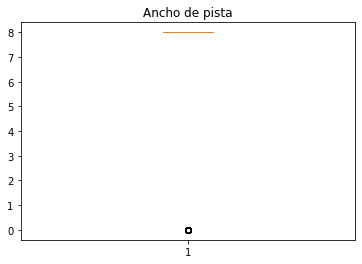

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Ancho de pista')
ax1.boxplot(np.array(aeropuertos.select('ancho_pista').collect()))

In [50]:
divipola.summary().show()

+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|summary|Código Departamento|  Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|          Longitud|           Latitud|     Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|  count|               9508|              9508|                 9508|               9508|            9508|                 9508|               9508|              9508|    

En la tabla anterior podemos observar datos estadísticos generales como el conteo, mínimo, máximo, desviación estándar y los percentiles de 25, 50 y 75 porciento. Dentro de esta tabla, se puede analizar que:
- Algunos valores vienen vacíos o nulos, lo que puede inferir que dichos campos no son obligatorios.

De igual forma, y para responder a la pregunta de "Estadisticas descriptivas por columna (numérica, categórica, fechas)", podemos observar estadísticas de orden, dentro de las cuales se tiene que:
- Todos los valores del código de departamento son 41, lo que indica que puede tratarse de un error debido a que si los departamentos cambian el código no puede ser el mismo.
- La desviación estándar del código de departamento es 0 debido a que los valores son los mismos, está correcta la desviación pero debe verificarse los datos del departamento.
- La desviación estándar del código de municipio es de 26.073 lo que indica que los valores no son iguales.
- Los valores del nombre de la ciudad son todos Neiva, por lo que el valor mínimo y máximo son los mismos, esto también puede tratarse de un error de datos.
- Los nombres de los departamentos cambian, pero mantienen el mismo nombre del municipio, lo que es un error en los datos.

También, mediante gráficas podemos observar la distribución de ciertos valores. Por ejemplo, a continuación, se muestra que el código del municipio es un valor cambiante que está entre los valores de menos de 20.000 y 100.000, pero teniendo su desviación estándar entre 20.000 y 40.000. 

{'whiskers': [<matplotlib.lines.Line2D at 0x21ea2e3e8c8>,
 'caps': [<matplotlib.lines.Line2D at 0x21ea2e27f08>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ea2dfd288>],
 'medians': [<matplotlib.lines.Line2D at 0x21ea0e66c88>],
 'fliers': [<matplotlib.lines.Line2D at 0x21ea0e66bc8>],
 'means': []}

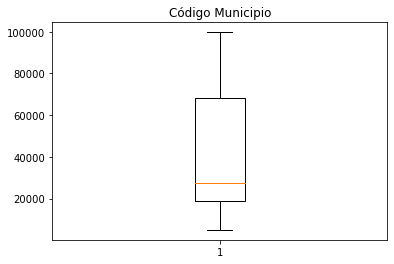

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Código Municipio')
ax1.boxplot(np.array(divipola.select('Código Municipio').collect()))

In [53]:
vuelos.summary().show()

+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|               ano|               mes|origen|destino|       tipo_equipo|tipo_vuelo|trafico|           empresa|            vuelos|           sillas|   carga_ofrecida|         pasajeros|       carga_bordo|
+-------+------------------+------------------+------+-------+------------------+----------+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            467990|            467990|115441| 115441|            467990|    467990| 467990|            467990|            467990|           467990|           467987|            467990|            467971|
|   mean|2009.0125451398535|6.5515397665929775|  null|   null| 627.5512585591667|      null|   null|              null|10.101587640761554|723.759932

En la tabla anterior podemos observar datos estadísticos generales como el conteo, mínimo, máximo, desviación estándar y los percentiles de 25, 50 y 75 porciento. Dentro de esta tabla, se puede analizar que:
- Algunos valores vienen vacíos o nulos, lo que puede inferir que dichos campos no son obligatorios.

De igual forma, y para responder a la pregunta de "Estadisticas descriptivas por columna (numérica, categórica, fechas)", podemos observar estadísticas de orden, dentro de las cuales se tiene que:
- El año promedio en que se realizaron los vuelos fue 2009 y el mes junio.
- Los valores promedios para el origen y destino son nulos, por lo que la información no es numérica.
- Se tiene en total 467.990 vuelos en el transcurso del tiempo, y se han ocupado un total de 467.990 sillas. La carga ofrecida ha sido de 467.987 y se han transportado un total de 467.990 pasajeros.
- El año donde se presentaron los primeros viajes fue 2004 y el mayor fue 2014.
- El número mayor de pasajeros que se han transportado a lo largo del tiempo es de 75.424.
- La mayor carga abordo que se ha transportado es de 5.963.894.
- Se han tenido 7.006 vuelos donde se han ocupado 700.063 sillas.

También, mediante gráficas podemos observar la distribución de ciertos valores. Por ejemplo, a continuación, se muestra los años en donde se han realizado los vuelos, dando como resultado que la mayoria de vuelos fueron efectuados en el año 2009, donde el límite inferior y superior es de 2004 y 2014, respectivamente, pero donde la mayor cantidad de vuelos se han realizado entre 2006 y 2012.

{'whiskers': [<matplotlib.lines.Line2D at 0x21ea086c408>,
 'caps': [<matplotlib.lines.Line2D at 0x21ea2d38188>,
 'boxes': [<matplotlib.lines.Line2D at 0x21eacc9a9c8>],
 'medians': [<matplotlib.lines.Line2D at 0x21ea2cfe648>],
 'fliers': [<matplotlib.lines.Line2D at 0x21ea2cfeec8>],
 'means': []}

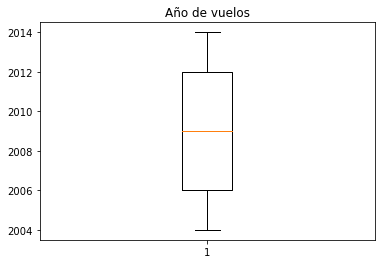

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Año de vuelos')
ax1.boxplot(np.array(vuelos.select('ano').collect()))

In [54]:
pib.summary().show()

+-------+----------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|summary|CodigoDepartamento(DIVIPOLA)|DEPARTAMENTOS|              2006|             2007|               2008|                2010|             2011|                2012|                2013|                2014|
+-------+----------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|  count|                          27|           27|                27|               27|                 27|                  27|               27|                  27|                  27|                  27|
|   mean|            48.7037037037037|         null| 6413240.740740741|7130828.037037037|  7851694.186446355|   8737185.290427044|9728735.962962963|1.03

En la tabla anterior podemos observar datos estadísticos generales como el conteo, mínimo, máximo, desviación estándar y los percentiles de 25, 50 y 75 porciento. Dentro de esta tabla, se puede analizar que:
- Algunos valores vienen vacíos o nulos, lo que puede inferir que dichos campos no son obligatorios.

De igual forma, y para responder a la pregunta de "Estadisticas descriptivas por columna (numérica, categórica, fechas)", podemos observar estadísticas de orden, dentro de las cuales se tiene que:
- Se tiene en total 27 registros para cada año, por lo que hay consistencia en datos para cada periodo de tiempo analizado.
- Se tiene que el valor de PIB promedio para el año 2006 es de 6.413.240; para el año 2007 es de 7.130.828; para el año 2008 es de 7.851.694; para el año 2010 es de 8.737.185; para el año 2011 es de 9.728.735, lo que se puede inferir que conforme pase el tiempo el valor de PIB aumenta.
- Se tienen nombres erróneos para departamentos, ya que no coinciden con los nombres reales de los departamentos de Colombia, como también hay inconsistencia en el formato y escritura con errores de ortografía.

También, mediante gráficas podemos observar la distribución de ciertos valores. Por ejemplo, a continuación, se muestra que para el PIB del año 2014 los valores están entre 0.5e7 y 2.5e7, pero su media se encuentra entre 1.0e7 y 1.5e7.

{'whiskers': [<matplotlib.lines.Line2D at 0x21ea2d62988>,
 'caps': [<matplotlib.lines.Line2D at 0x21ea2d5e288>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ea2d1bc48>],
 'medians': [<matplotlib.lines.Line2D at 0x21ea1a50ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x21ea1a50608>],
 'means': []}

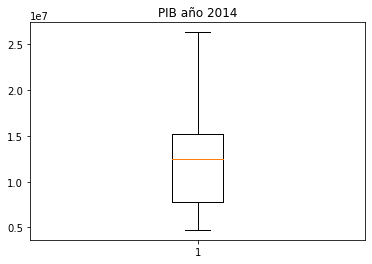

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB año 2014')
ax1.boxplot(np.array(pib.select('2014').collect()))

In [55]:
proyecciones.summary().show()

+-------+-----------------+----+--------+-----------------+------------------+
|summary|             Anio|  DP|   DPNOM|    Total Hombres|     Total Mujeres|
+-------+-----------------+----+--------+-----------------+------------------+
|  count|              330| 330|     330|              330|               330|
|   mean|           2009.5|25.0|    null|650666.4242424242| 843740.4454545454|
| stddev|2.876643180486918| 0.0|    null|751024.7851013226|3097897.0672473223|
|    min|             2005|  25|amazonas|            13825|             11636|
|    25%|             2007|  25|    null|           173396|            170374|
|    50%|             2009|  25|    null|           477977|            489035|
|    75%|             2012|  25|    null|           777720|            795592|
|    max|             2014|  25| vichada|          3476538|          55000000|
+-------+-----------------+----+--------+-----------------+------------------+



En la tabla anterior podemos observar datos estadísticos generales como el conteo, mínimo, máximo, desviación estándar y los percentiles de 25, 50 y 75 porciento. Dentro de esta tabla, se puede analizar que:
- Algunos valores vienen vacíos o nulos, lo que puede inferir que dichos campos no son obligatorios.

De igual forma, y para responder a la pregunta de "Estadisticas descriptivas por columna (numérica, categórica, fechas)", podemos observar estadísticas de orden, dentro de las cuales se tiene que:
- El año donde se tiene el promedio de registros corresponde al año 2009.
- Se tiene en total un promediio de 650.666 hombres y 843.740 mujeres.
- El número mínimo de hombres es de 13.825 mientras que el número mínimo de mujeres es de 11.636.
- El número máximo de hombres es de 3.476.538 mientras que el número máximo de mujeres es de 55.000.000.
- En cuanto departamentos, se tiene que el menor es Amazonas y el mayor Vichada.

También, mediante gráficas podemos observar la distribución de ciertos valores. Por ejemplo, a continuación, se muestra que en cuanto al número de hoombres, estos se encuentra entre 0.3e6 y 3.5e6, teniendo como media 0.5e6, pero teniendo entre 0.2e6 y 0.8e6 la cantidad mas demandante.

{'whiskers': [<matplotlib.lines.Line2D at 0x21ea2f0e748>,
 'caps': [<matplotlib.lines.Line2D at 0x21ea8f30508>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ea2f16a08>],
 'medians': [<matplotlib.lines.Line2D at 0x21ea8f370c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x21ea8f37708>],
 'means': []}

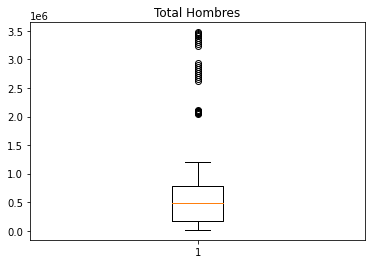

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Total Hombres')
ax1.boxplot(np.array(proyecciones.select('Total Hombres').collect()))

## Análisis de calidad de datos
La calidad de los datos se valida en cuanto a la idoneidad de:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores


### Completitud

#### Verificación de valores nulos o vacíos

In [41]:
# Calcular el número total de filas
total_filas = movimientos.count()

# Calcular el número de valores incompletos (nulos o vacíos) por columna
incompletos_por_columna = movimientos.select(
    [count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) for c in movimientos.columns]
).collect()[0]

# Calcular la completitud por columna
completitud_por_columna = {c: (1 - (incompletos_por_columna[c] / total_filas)) * 100 for c in movimientos.columns}

for c, comp in completitud_por_columna.items():
    print(f"Completitud de la columna {c}: {comp:.3f}%")

Completitud de la columna TransaccionProductoID: 100.00%
Completitud de la columna ProductoID: 100.00%
Completitud de la columna TipoTransaccionID: 100.00%
Completitud de la columna ClienteID: 100.00%
Completitud de la columna InvoiceID: 100.00%
Completitud de la columna ProveedorID: 3.48%
Completitud de la columna OrdenDeCompraID: 3.48%
Completitud de la columna FechaTransaccion: 100.00%
Completitud de la columna Cantidad: 100.00%



#### Comprobación

In [38]:
total_filas = movimientos.count()
# Verificar la relación entre TipoTransaccionID y valores vacíos en ProveedorID y OrdenDeCompraID
proveedor_vacio_por_tipo = movimientos.filter(col("ProveedorID") == "").groupBy("TipoTransaccionID").count()
orden_vacio_por_tipo = movimientos.filter(col("OrdenDeCompraID") == "").groupBy("TipoTransaccionID").count()

proveedor_vacio_por_tipo.show()
orden_vacio_por_tipo.show()

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               12|    46|
|               10|197136|
+-----------------+------+

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               12|    46|
|               10|197136|
+-----------------+------+



### Unicidad

#### Verificación de registros duplicados

In [23]:
# Columnas para identificar duplicados
key_columns = ["TransaccionProductoID", "ProductoID", "TipoTransaccionID", "ClienteID", "InvoiceID", "ProveedorID", "OrdenDeCompraID", "FechaTransaccion", "Cantidad"]
# Contar las ocurrencias de cada combinación de las columnas
duplicates = movimientos.groupBy(key_columns).count()
# Se filtrar aquellos registros que tienen más de una ocurrencia
duplicates = duplicates.filter(col("count") > 1)
duplicates.show()
# Total de duplicados
total_duplicates = duplicates.count()
print(f"Total de registros duplicados: {total_duplicates}")

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+-----+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|count|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+-----+
|               270985|       216|               10|    510.0|  56780.0|           |               |2015-10-16 12:00:...|   -10.0|    2|
|               118236|       119|               10|    425.0|  24762.0|           |               |2014-04-23 12:00:...|   -10.0|    2|
|               265915|       152|               10|    911.0|  55734.0|           |               |2015-09-29 12:00:...|   -10.0|    2|
|               261670|        42|               10|    995.0|  54844.0|           |               |2015-09-15 12:00:...|   -10.0|    2|
|               218629|        65|       

### Consistencia

#### Verificación consistencia estructural

In [24]:
# Tipos de datos de las columnas
movimientos.printSchema()
# Verificar la longitud de los valores en columnas de tipo string
from pyspark.sql.functions import length
string_columns = [field.name for field in movimientos.schema.fields if field.dataType == StringType()]
movimientos.select([length(col(c)).alias(c) for c in string_columns]).summary().show()

root
 |-- TransaccionProductoID: integer (nullable = true)
 |-- ProductoID: integer (nullable = true)
 |-- TipoTransaccionID: integer (nullable = true)
 |-- ClienteID: double (nullable = true)
 |-- InvoiceID: double (nullable = true)
 |-- ProveedorID: string (nullable = true)
 |-- OrdenDeCompraID: string (nullable = true)
 |-- FechaTransaccion: string (nullable = true)
 |-- Cantidad: double (nullable = true)

+-------+-------------------+-------------------+------------------+
|summary|        ProveedorID|    OrdenDeCompraID|  FechaTransaccion|
+-------+-------------------+-------------------+------------------+
|  count|             204292|             204292|            204292|
|   mean|0.10440937481643922|0.19980713880132359|21.967673721927437|
| stddev| 0.5498438749162375| 1.0553991369448272|7.4292114553489785|
|    min|                  0|                  0|                11|
|    25%|                  0|                  0|                11|
|    50%|                  0|      

#### Verificación consistencia de contenido

In [42]:
# Se define los tipos de transacción permitidos para cantidades negativas
tipos_transaccion_permitidos = [2, 4, 6, 8, 10, 12, 13]
# Filtrar registros con cantidad negativa que no corresponden a los tipos de transacción permitidos
cantidad_negativa_inconsistente = movimientos.filter((col("Cantidad") < 0) & (~col("TipoTransaccionID").isin(tipos_transaccion_permitidos))).count()
print(f"Cantidad de registros con cantidad negativa inconsistente: {cantidad_negativa_inconsistente}")

Cantidad de registros con cantidad negativa inconsistente: 0


### Validez

#### Verificación valores en rangos específicos

In [29]:
# Cantidades dentro de los rangos esperados no más de 50 millones por transacción
cantidades_invalidas = movimientos.filter((col("Cantidad") < -50000000) | (col("Cantidad") > 50000000)).count()
print(f"Cantidad de registros con cantidades fuera del rango permitido: {cantidades_invalidas}")

Cantidad de registros con cantidades fuera del rango permitido: 0


## Entendimiento de datos

### Analizar la correlación lineal

In [35]:
# Calcular la correlación entre TipoTransaccionID y Cantidad
correlacion = movimientos.select(corr("TipoTransaccionID", "Cantidad")).collect()[0][0]
print(f"Correlación entre TipoTransaccionID y Cantidad: {correlacion}")

Correlación entre TipoTransaccionID y Cantidad: 0.8336502987666313


## Conclusiones/resultados

**Conclusiones generales:**

El análisis de la tabla ....

**Conclusiones de reglas de negocio:**

- 
- 
- 
- 
- 

**Conclusiones de calidad:**

- 
- 
- 
- 

**Sección de correlación**





## Para la organización

**Preguntas y aclaraciones**
- 
- 
- 
- 
- 
- 

**Problemas de calidad y alternativas para la limpieza**

- 
- 
- 